# For Mounting The Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/NLP-Project

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/NLP-Project


# Installing Transformers

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00


# Importing Libraries


In [ ]:
# Basic Python Libraries 
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
# Misc.
import warnings
warnings.filterwarnings('ignore')

# Setting Up Graph Designs & Color Pallets for Data Visualization

In [ ]:
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading Data from File

In [5]:
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/NLP-Project/yelp.csv'
df = pd.read_csv(csv_file_path)
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [6]:
df.isnull().sum()

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64

# Getting Bert Tokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Checking for Tokenizer Tokens

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

# Plotting Token Count

In [ ]:
token_lens = []
for txt in df.text:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))

# Plotting the data
sns.distplot(token_lens)
plt.xlim([0,256])
plt.xlabel('Token count')

In [10]:
print(df.isnull().sum())

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64


# Final Output Star Rating Function

In [ ]:
# Make the customer stars starting from 0 instead of 1 so that we are using index based approach
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

df['stars'] = df.stars.apply(map_sentiment_scores)    

# GPReviewDataset Class

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# Splitting Dataset into; Train, Test and Validation Sets

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# Printing the shape of every dataset
print(df_train.shape, df_val.shape, df_test.shape)

# Data Loader Function

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.stars.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

# Hyperparameters

In [ ]:
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 10

# Data Loaders for Train, Test & Validation

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Testing to see if data loaders are fine or not

In [ ]:
# Testing
data = next(iter(train_data_loader))

print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

# Getting the Pre Trained Bert Uncased Model

In [18]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# SentimentClassifier Model Class

In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
        return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

# Training One Epoch Function

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        # Backward prop
        loss.backward()
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

# Model Evaluation Function

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
           
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

# Prediction Function

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
# Setting Up Class Names
class_names = ['1-star', '2-star', '3-star', '4-star', '5-star']

# Confusion Matrix Plot Function

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

# Instantiating the Model for Training

In [54]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Optimizer & Loss Functions

In [ ]:
# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [56]:
print(bert_model.config.hidden_size)

768


# Model Training

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print("Trained" )
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance then save the best model so far
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

# Saving the Last EPOCH Model

In [ ]:
# Saving the Final Model of Last EPOCH with the Newest Weights 
torch.save(model.state_dict(), 'model_state_newest.pth')

# **Loading the Fine-Tuned Model**
Note: If you want to use the already trained model then run this code and ignore the above training code

In [26]:
model = SentimentClassifier(len(class_names))
model = model.to(device)
model.load_state_dict(torch.load('model_state_dict.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

# Testing the Model on Test Set

In [27]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

# Showing the Evaluation Metrics

              precision    recall  f1-score   support

      1-star       0.73      0.52      0.61        73
      2-star       0.44      0.46      0.45        78
      3-star       0.47      0.46      0.47       137
      4-star       0.60      0.67      0.63       377
      5-star       0.69      0.65      0.67       335

    accuracy                           0.60      1000
   macro avg       0.59      0.55      0.56      1000
weighted avg       0.61      0.60      0.61      1000



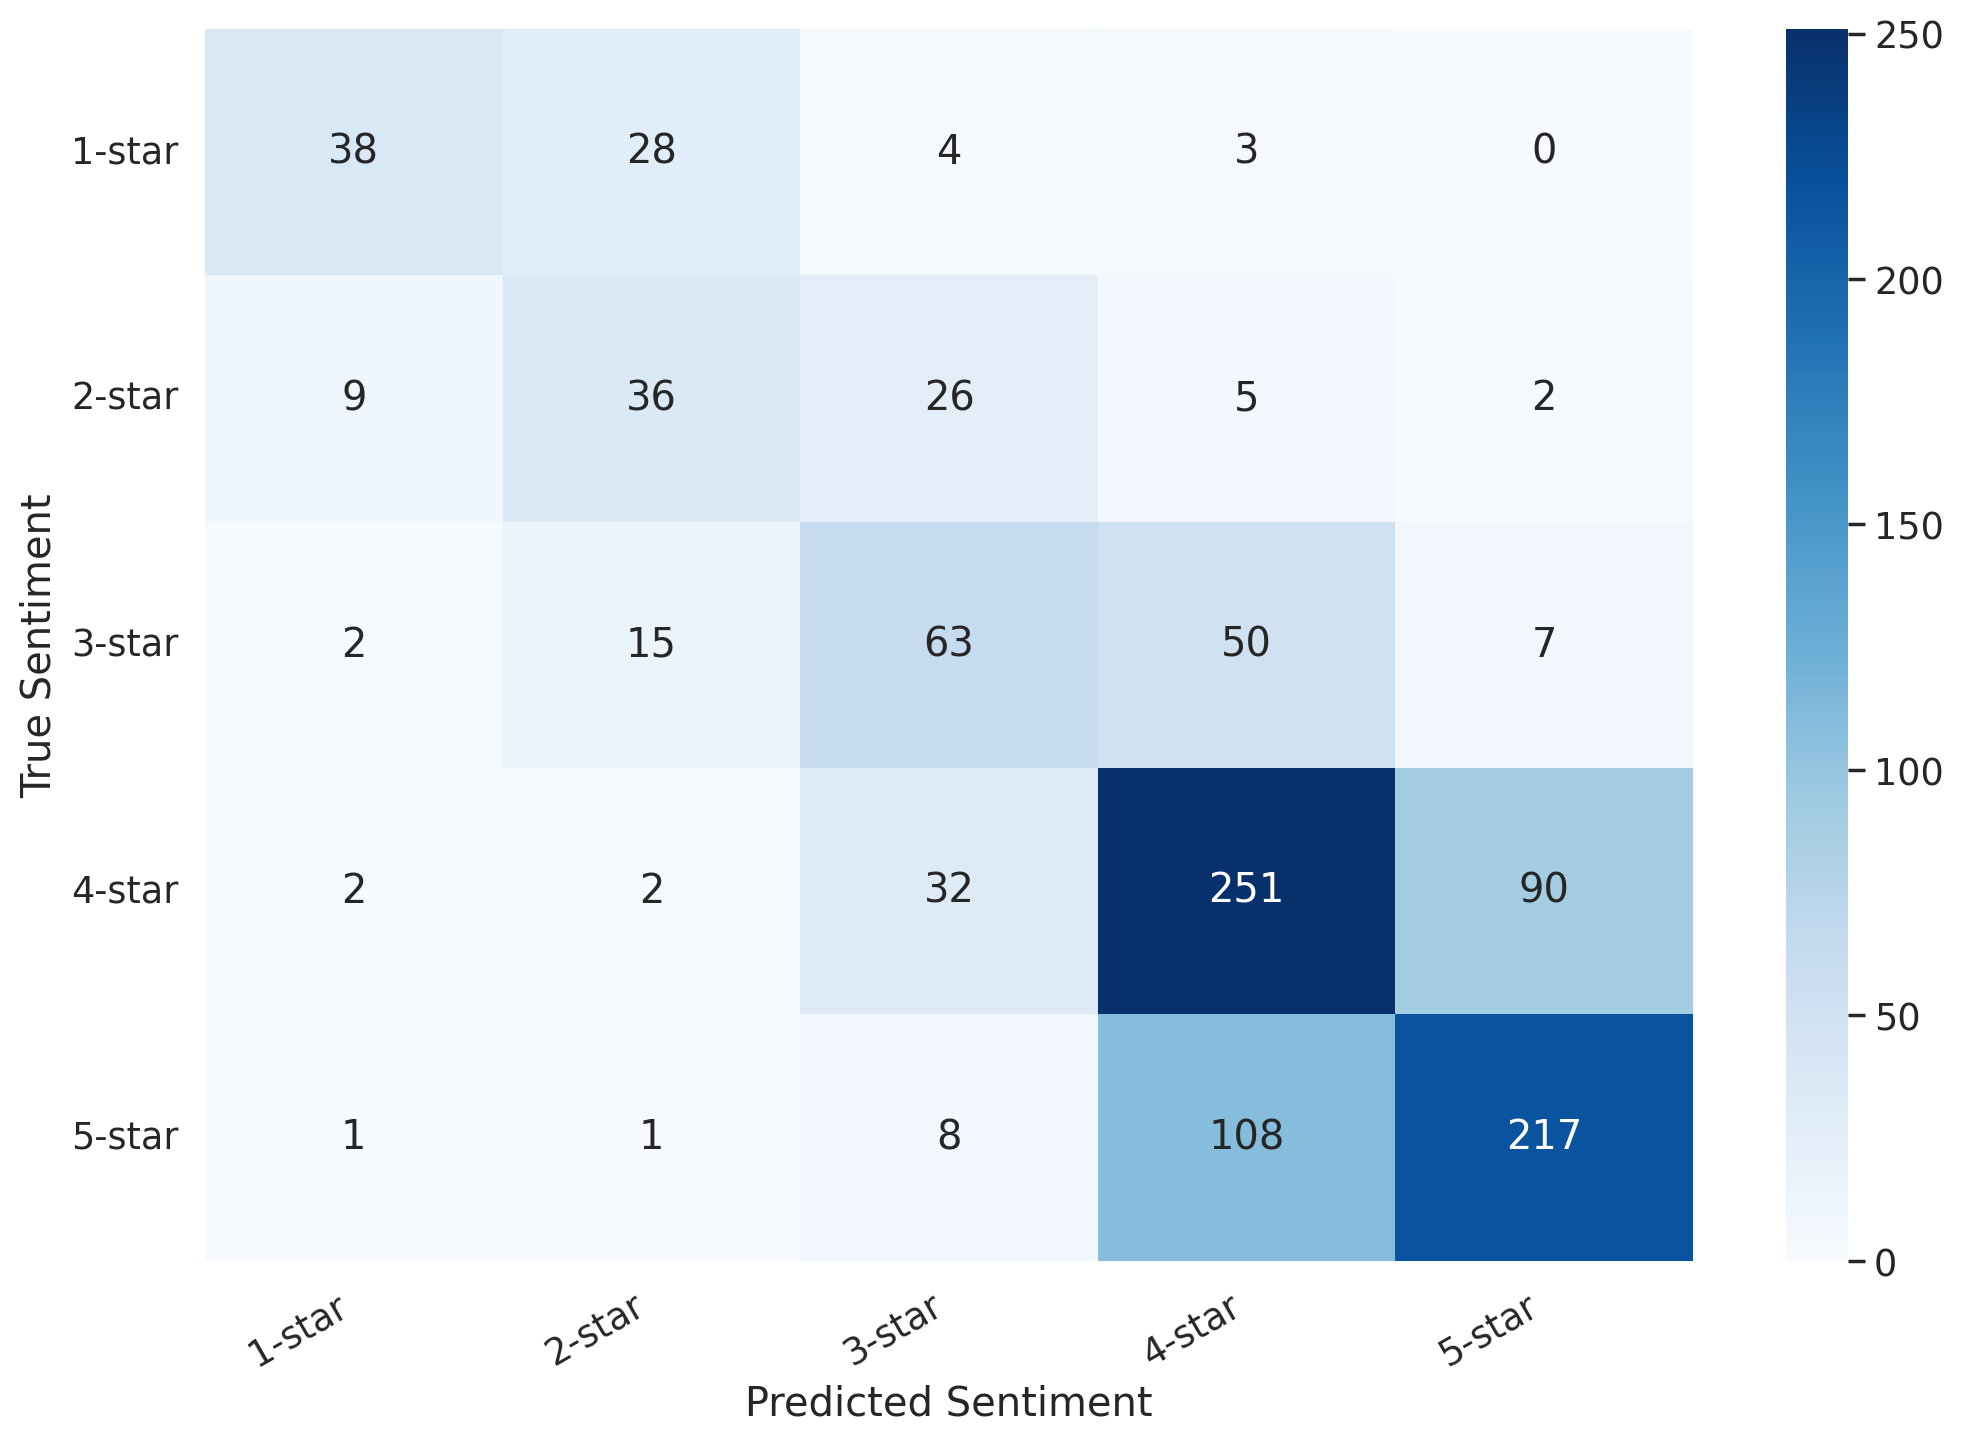

In [28]:
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

# Testing Examples

## Example 01

In [ ]:
review_text = "I could share photos seamlessly with this app"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

## Example 02

In [30]:
review_text = "I could share photos seamlessly with this app, but the UI could be better"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I could share photos seamlessly with this app, but the UI could be better
Sentiment  : 3-star
